# Imports

In [1]:
import keras
import mdn
from scipy.stats import norm
from sklearn.metrics import classification_report
from sklearn.metrics import log_loss
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


# Load data

In [2]:
X_train = pd.read_csv('./data/X_train_normal.csv', usecols=['GAME_TIME', 'HT_SCORE_DIFF','HT_POSS'])
X_test_internal = pd.read_csv('./data/X_test_internal_normal.csv', usecols=['GAME_TIME', 'HT_SCORE_DIFF','HT_POSS'])
X_test_external = pd.read_csv('./data/X_test_external_normal.csv', usecols=['GAME_TIME', 'HT_SCORE_DIFF','HT_POSS'])
Y_train = pd.read_csv('./data/Y_train_binary.csv')
Y_test_internal = pd.read_csv('./data/Y_test_internal_binary.csv')
Y_test_external = pd.read_csv('./data/Y_test_external_binary.csv')
Y_train_continuous = pd.read_csv('./data/Y_train_continuous.csv')
Y_test_internal_continuous = pd.read_csv('./data/Y_test_internal_continuous.csv')
Y_test_external_continuous = pd.read_csv('./data/Y_test_external_continuous.csv')

# Define neural network architecture

In [3]:
N_HIDDEN = 4
N_MIXES = 3
OUTPUT_DIMS = 1
num_input_features = X_train.shape[1]
model = keras.Sequential()
model.add(keras.layers.Dense(N_HIDDEN, input_dim=num_input_features, activation='tanh'))
model.add(mdn.MDN(OUTPUT_DIMS, N_MIXES))
model.compile(loss=mdn.get_mixture_loss_func(1, N_MIXES), optimizer=keras.optimizers.Adam())
model.summary()

W0117 09:20:45.793136 4526343616 deprecation_wrapper.py:119] From /Users/henrypoole/anaconda3/envs/thesis-v2/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0117 09:20:45.818748 4526343616 deprecation_wrapper.py:119] From /Users/henrypoole/anaconda3/envs/thesis-v2/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0117 09:20:45.821008 4526343616 deprecation_wrapper.py:119] From /Users/henrypoole/anaconda3/envs/thesis-v2/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0117 09:20:45.874220 4526343616 deprecation_wrapper.py:119] From /Users/henrypoole/anaconda3/envs/thesis-v2/lib/python3.6/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 4)                 16        
_________________________________________________________________
mdn_1 (MDN)                  (None, 9)                 45        
Total params: 61
Trainable params: 61
Non-trainable params: 0
_________________________________________________________________


# Fit model

In [4]:
model_fit = model.fit(x=X_train, y=Y_train_continuous, epochs=5, validation_data=(X_test_internal, Y_test_internal_continuous), batch_size=32)

W0117 09:20:46.448911 4526343616 deprecation_wrapper.py:119] From /Users/henrypoole/anaconda3/envs/thesis-v2/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0117 09:20:46.537106 4526343616 deprecation_wrapper.py:119] From /Users/henrypoole/anaconda3/envs/thesis-v2/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Train on 1989224 samples, validate on 224771 samples
Epoch 1/5
1989224/1989224 [==============================] - 224s 113us/step - loss: 3.8872 - val_loss: 3.5879
Epoch 2/5
1989224/1989224 [==============================] - 222s 112us/step - loss: 3.5555 - val_loss: 3.5800
Epoch 3/5
1989224/1989224 [==============================] - 224s 113us/step - loss: 3.5514 - val_loss: 3.5778
Epoch 4/5
1989224/1989224 [==============================] - 243s 122us/step - loss: 3.5491 - val_loss: 3.5773
Epoch 5/5
1989224/1989224 [==============================] - 251s 126us/step - loss: 3.5476 - val_loss: 3.5781


# Save model

In [5]:
model_json = model.to_json()
with open("base_mdn_model_{}mixes.json".format(N_MIXES), "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("base_mdn_model_{}mixes.h5".format(N_MIXES))

# Plot training/validation loss

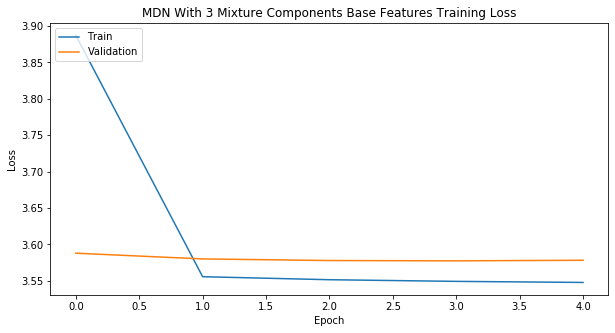

In [6]:
plt.figure(figsize=(10, 5))
plt.plot(model_fit.history['loss'])
plt.plot(model_fit.history['val_loss'])
plt.title('MDN With {} Mixture Components Base Features Training Loss'.format(N_MIXES))
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Make binary class and probabilistic predictions

In [7]:
# Define helper functions

# calculate cdf of mixture
def calculate_mixture_cdf(mus, sigmas, weights, x=0):
    mixture_cdf = 0.0
    for component_num, weight in enumerate(weights):
        #print('Mu =  ', mus[component_num])
        #print('Sigma = ', sigmas[component_num])
        #print('Weight = ', weight)
        component_dist = norm(loc=mus[component_num], scale=sigmas[component_num])
        component_cdf = component_dist.cdf(x)
        #print('Component CDF = ', component_cdf)
        mixture_cdf += (component_cdf * weight)
        
    return mixture_cdf

# calculate win prob as 1 - cdf
def calculate_home_team_win_prob(mus, sigmas, weights):
    home_team_win_prob = 1 - calculate_mixture_cdf(mus, sigmas, weights)
    return home_team_win_prob

# mdn predict function
def mdn_predict(mdn_model, x, num_mixes, num_output_dims):
    pred_raw_params = mdn_model.predict(x)
    pred_split_params = np.apply_along_axis(mdn.split_mixture_params, 1, pred_raw_params, num_output_dims, num_mixes)
    pred_split_params[:, 2, :] = np.apply_along_axis(mdn.softmax, axis=1, arr=pred_split_params[:, 2, :])
    pred_mus = pred_split_params[:, 0, :]
    pred_sigmas = np.sqrt(pred_split_params[:, 1, :])
    pred_weights = pred_split_params[:, 2, :]
    pred_win_prob = np.zeros(pred_split_params.shape[0])
    for i in range(len(pred_win_prob)):
        pred_win_prob[i] = calculate_home_team_win_prob(pred_mus[i, :], pred_sigmas[i, :], pred_weights[i, :])
        
    return pred_win_prob

In [8]:
# Make probabilistic predictions
Y_train_prob_pred = mdn_predict(model, X_train, N_MIXES, OUTPUT_DIMS)
Y_test_internal_prob_pred = mdn_predict(model, X_test_internal, N_MIXES, OUTPUT_DIMS)
Y_test_external_prob_pred = mdn_predict(model, X_test_external, N_MIXES, OUTPUT_DIMS)

# Convert to binary predictions
Y_train_class_pred = np.where(Y_train_prob_pred <= 0.5, 0, 1)
Y_test_internal_class_pred = np.where(Y_test_internal_prob_pred <= 0.5, 0, 1)
Y_test_external_class_pred = np.where(Y_test_external_prob_pred <= 0.5, 0, 1)

# Save predictions as .csv
Y_train_pred = pd.DataFrame({'class_pred':Y_train_class_pred, 'prob_pred':Y_train_prob_pred})
Y_train_pred.to_csv('./data/base_mdn_{}mixes_train_predictions.csv'.format(N_MIXES), index=False)

Y_test_internal_pred = pd.DataFrame({'class_pred':Y_test_internal_class_pred, 'prob_pred':Y_test_internal_prob_pred})
Y_test_internal_pred.to_csv('./data/base_mdn_{}mixes_test_internal_predictions.csv'.format(N_MIXES), index=False)

Y_test_external_pred = pd.DataFrame({'class_pred':Y_test_external_class_pred, 'prob_pred':Y_test_external_prob_pred})
Y_test_external_pred.to_csv('./data/base_mdn_{}mixes_test_external_predictions.csv'.format(N_MIXES), index=False)

# Evaluate Results

In [9]:
# Classification reports
train_classification_report = classification_report(Y_train, Y_train_class_pred, target_names=['Away Team Win', 'Home Team Win'], digits=4)
test_internal_classification_report = classification_report(Y_test_internal, Y_test_internal_class_pred, target_names=['Away Team Win', 'Home Team Win'], digits=4)
test_external_classification_report = classification_report(Y_test_external, Y_test_external_class_pred, target_names=['Away Team Win', 'Home Team Win'], digits=4)

In [10]:
print(train_classification_report)

               precision    recall  f1-score   support

Away Team Win     0.7381    0.5549    0.6335    779434
Home Team Win     0.7528    0.8732    0.8085   1209790

     accuracy                         0.7484   1989224
    macro avg     0.7454    0.7140    0.7210   1989224
 weighted avg     0.7470    0.7484    0.7399   1989224



In [11]:
print(test_internal_classification_report)

               precision    recall  f1-score   support

Away Team Win     0.7653    0.5616    0.6478     96760
Home Team Win     0.7241    0.8698    0.7903    128011

     accuracy                         0.7372    224771
    macro avg     0.7447    0.7157    0.7191    224771
 weighted avg     0.7419    0.7372    0.7290    224771



In [12]:
print(test_external_classification_report)

               precision    recall  f1-score   support

Away Team Win     0.7572    0.5754    0.6539    104262
Home Team Win     0.7076    0.8478    0.7714    126379

     accuracy                         0.7247    230641
    macro avg     0.7324    0.7116    0.7127    230641
 weighted avg     0.7300    0.7247    0.7183    230641



In [13]:
# Calculate log loss
train_log_loss = log_loss(Y_train, Y_train_prob_pred)
test_internal_log_loss = log_loss(Y_test_internal, Y_test_internal_prob_pred)
test_external_log_loss = log_loss(Y_test_external, Y_test_external_prob_pred)

In [14]:
print(train_log_loss)

0.6037827151097769


In [15]:
print(test_internal_log_loss)

0.6594620050393231


In [16]:
print(test_external_log_loss)

0.6875015326906603


In [17]:
# Calculate area under ROC curve

def plot_roc_curve(true, pred, title):
    fpr, tpr, threshold = roc_curve(true, pred)
    roc_auc = auc(fpr, tpr)
    plt.title('{} ROC Curve'.format(title))
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.4f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

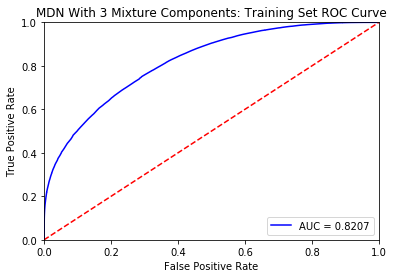

In [18]:
plot_roc_curve(Y_train, Y_train_prob_pred, 'MDN With {} Mixture Components: Training Set'.format(N_MIXES))

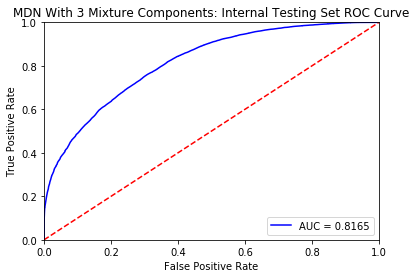

In [19]:
plot_roc_curve(Y_test_internal, Y_test_internal_prob_pred, 'MDN With {} Mixture Components: Internal Testing Set'.format(N_MIXES))

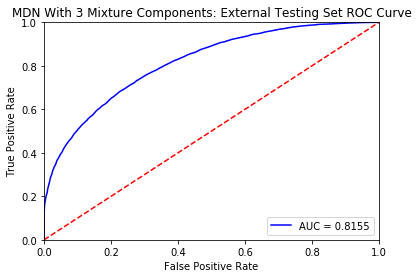

In [20]:
plot_roc_curve(Y_test_external, Y_test_external_prob_pred, 'MDN With {} Mixture Components: External Testing Set'.format(N_MIXES))